In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

from pyspark import SparkContext
sc = SparkContext("local", "Task-1")

In [2]:
from pyspark.sql.session import SparkSession
import pyspark.sql.types as tp

my_schema = tp.StructType([
    tp.StructField(name= 'PatientId',      dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'AppointmentID', dataType= tp.StringType(),    nullable= True),
    tp.StructField(name= 'Gender',       dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'ScheduledDay',  dataType= tp.TimestampType(),    nullable= True),
    tp.StructField(name= 'AppointmentDay',   dataType= tp.TimestampType(),    nullable= True),
    tp.StructField(name= 'Age',       dataType= tp.IntegerType(),    nullable= True),
    tp.StructField(name= 'Neighbourhood',    dataType= tp.StringType(),   nullable= True),
    tp.StructField(name= 'Scholarship',           dataType= tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'Hipertension',       dataType=tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'Diabetes',   dataType= tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'Alcoholism',     dataType= tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'Handcap',         dataType= tp.IntegerType(),    nullable= True),
    tp.StructField(name= 'SMS_received',         dataType= tp.IntegerType(),   nullable= True),
    tp.StructField(name= 'No-show',    dataType= tp.StringType(), nullable= True)    
])

sp = SparkSession(sc)
df = sp.read.csv('KaggleV2-May-2016.csv',header=True,schema=my_schema)
df.printSchema()

root
 |-- PatientId: string (nullable = true)
 |-- AppointmentID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- ScheduledDay: timestamp (nullable = true)
 |-- AppointmentDay: timestamp (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Neighbourhood: string (nullable = true)
 |-- Scholarship: integer (nullable = true)
 |-- Hipertension: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Alcoholism: integer (nullable = true)
 |-- Handcap: integer (nullable = true)
 |-- SMS_received: integer (nullable = true)
 |-- No-show: string (nullable = true)



In [3]:
import pandas as pd
pd.DataFrame(df.take(5),columns = df.columns)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.groupBy('Neighbourhood').count().show()

+-----------------+-----+
|    Neighbourhood|count|
+-----------------+-----+
|   BENTO FERREIRA|  318|
|   JARDIM CAMBURI|  674|
|         GURIGICA|  603|
|    SÃO CRISTÓVÃO|  328|
|     FONTE GRANDE|   55|
|        FRADINHOS|  152|
|         NAZARETH|   70|
|          PIEDADE|   33|
|      SANTA CLARA|  165|
|      SANTOS REIS|  122|
|     SOLON BORGES|   93|
|    SANTO ANTÔNIO|  972|
|     PRAIA DO SUÁ|  326|
|PONTAL DE CAMBURI|    7|
|       BELA VISTA|  972|
|         DA PENHA|  350|
|        CONQUISTA|  186|
|       CRUZAMENTO|  863|
|       GOIABEIRAS|  217|
|       TABUAZEIRO|  515|
+-----------------+-----+
only showing top 20 rows



In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator,VectorAssembler
from pyspark.ml import Pipeline

df_final = df.select(['Gender','Age','Neighbourhood','Scholarship','Hipertension',
                      'Diabetes','Alcoholism','Handcap','SMS_received','No-show'])

df_final = df_final.na.drop()

In [6]:
pd.DataFrame(df_final.take(5),columns = df_final.columns)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [7]:
## STAGE 1 : Ubah kolom gender menjadi numeric
stage_1 = StringIndexer(inputCol= 'Gender', outputCol= "Gender_encoded")

## STAGE 2 : Ubah kolom neighbourhood menjadi numeric
stage_2 = StringIndexer(inputCol= 'Neighbourhood', outputCol= "N_encoded")

## STAGE 3 : Ubah kolom target menjadi numeric
stage_3 = StringIndexer(inputCol= 'No-show', outputCol= "No-show_encoded")

## STAGE 4 : Melakukan onehot encoding pada kolom gender
stage_4 = OneHotEncoderEstimator(inputCols=[stage_1.getOutputCol()], 
                                 outputCols= ["Gender_OHE"])

stage_5 = OneHotEncoderEstimator(inputCols=["Scholarship"], 
                                 outputCols= ["S_OHE"])

stage_6 = OneHotEncoderEstimator(inputCols=["Hipertension"], 
                                 outputCols= ["H_OHE"])

stage_7 = OneHotEncoderEstimator(inputCols=["Diabetes"], 
                                 outputCols= ["D_OHE"])

stage_8 = OneHotEncoderEstimator(inputCols=["Alcoholism"], 
                                 outputCols= ["A_OHE"])

stage_9= OneHotEncoderEstimator(inputCols=["Handcap"], 
                                 outputCols= ["Handcap_OHE"])

stage_10 = OneHotEncoderEstimator(inputCols=["SMS_received"], 
                                 outputCols= ["Sms_OHE"])

## STAGE 5 : VECTORIZATION
stage_final = VectorAssembler(
    inputCols=['Gender_OHE','Age','H_OHE','D_OHE','A_OHE','Handcap_OHE','Sms_OHE'],
    outputCol="features")

pipeline = Pipeline(stages = [stage_1,stage_2,stage_3,stage_4,stage_5,stage_6,stage_7,stage_8,stage_9,stage_10,stage_final])
pipelineModel = pipeline.fit(df_final)
df_final = pipelineModel.transform(df_final)
df_final = df_final.select(['No-show_encoded','features'])

In [8]:
train, test = df_final.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 22701
Test Dataset Count: 9641


In [9]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'No-show_encoded')
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

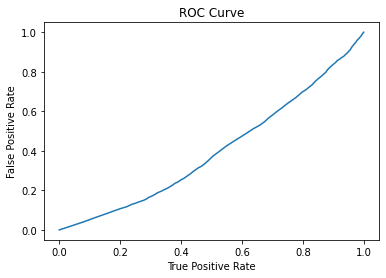

Training set areaUnderROC: 0.598319428393696


In [10]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['TPR'],roc['FPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [11]:
predictions = lrModel.transform(test)
predictions.select('features','No-show_encoded', 'rawPrediction', 'prediction', 'probability').show(20)

+--------------------+---------------+--------------------+----------+--------------------+
|            features|No-show_encoded|       rawPrediction|prediction|         probability|
+--------------------+---------------+--------------------+----------+--------------------+
|(9,[0,1,2,5],[1.0...|            0.0|[1.09073665444486...|       0.0|[0.74852041305943...|
|(9,[0,1,3,5],[1.0...|            0.0|[0.92096826949453...|       0.0|[0.71523935619791...|
|(9,[0,1,3,5],[1.0...|            0.0|[0.92916900531098...|       0.0|[0.71690666427857...|
|(9,[0,1,3,5],[1.0...|            0.0|[1.01937709929185...|       0.0|[0.73485124820207...|
|(9,[0,1,3,5],[1.0...|            0.0|[1.06858151419051...|       0.0|[0.74432706546809...|
|(9,[0,1,3,5],[1.0...|            0.0|[1.11778592908916...|       0.0|[0.75357779811759...|
|(9,[0,1,4,5],[1.0...|            0.0|[0.85495526070574...|       0.0|[0.70160558729656...|
|(9,[0,1,4,5],[1.0...|            0.0|[0.89595893978796...|       0.0|[0.7101183